# TFRS Two-tower Retrieval Model on ML-1m

## Setup

In [ ]:
!pip install -q tensorflow_recommenders

     |████████████████████████████████| 85 kB 550 kB/s 


In [ ]:
import os
import pprint
import tempfile
import matplotlib.pyplot as plt
from typing import Dict, Text

import numpy as np
import tensorflow as tf
from typing import Dict, Text
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

plt.style.use('ggplot')

## Data Loading and Processing

In [ ]:
# Ratings data.
ratings = tfds.load("movielens/1m-ratings", split="train", shuffle_files=True)
# Features of all the available movies.
movies = tfds.load("movielens/1m-movies", split="train", shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0.incomplete4B0PBX/movielens-train.tfrecord


  0%|          | 0/1000209 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/1m-movies/0.1.0.incomplete9YE8X5/movielens-train.tfrecord


  0%|          | 0/3883 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/1m-movies/0.1.0. Subsequent calls will reuse this data.


In [ ]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([ 5, 16]),
 'movie_id': b'2391',
 'movie_title': b'Simple Plan, A (1998)',
 'timestamp': 967497374,
 'user_gender': False,
 'user_id': b'3483',
 'user_occupation_label': 6,
 'user_occupation_text': b'executive/managerial',
 'user_rating': 4.0,
 'user_zip_code': b'30260'}


In [ ]:
#The movies dataset contains the movie id, movie title, and data on what genres it belongs to. Note that the genres are encoded with integer labels:
#View the data from movies dataset:
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'movie_genres': array([5, 7]),
 'movie_id': b'1729',
 'movie_title': b'Jackie Brown (1997)'}


In [ ]:
type(ratings)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

We're only going to extract the movie title and the user id. So, we're actually not going to extract the rating itself and the reason why is that we're treating these as implicit recommendations in this case because that's easier to do a large scale like we mentioned earlier we want to try to keep things simple in the retrieval stage because it's operating over potentially a massive amount of data so to that end we're just going to assume that any movie that a user rated is one that they were really interested in if they took the time to watch it then it expresses some level of interest:

In [ ]:
#Let's select the necessary attributes:

ratings = ratings.map(lambda x: {
                                 "movie_title": x["movie_title"],
                                 "user_id": x["user_id"],
                                })

movies = movies.map(lambda x: x["movie_title"])

In [ ]:
# let's use a random split, putting 75% of the ratings in the train set, and 25% in the test set:
# Assign a seed=42 for consistency of results and reproducibility:
seed = 42
l = len(ratings)

tf.random.set_seed(seed)
shuffled = ratings.shuffle(l, seed=seed, reshuffle_each_iteration=False)

#Save 75% of the data for training and 25% for testing:
train_ = int(0.75 * l)
test_ = int(0.25 * l)

train = shuffled.take(train_)
test = shuffled.skip(train_).take(test_)

In [ ]:
# Now, let's find out how many uniques users/movies:
movie_titles = movies.batch(l)
user_ids = ratings.batch(l).map(lambda x: x["user_id"])

#Movies uniques:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))

#users unique
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# take a look at the movies:
unique_movie_titles[:10]

array([b'$1,000,000 Duck (1971)', b"'Night Mother (1986)",
       b"'Til There Was You (1997)", b"'burbs, The (1989)",
       b'...And Justice for All (1979)', b'1-900 (1994)',
       b'10 Things I Hate About You (1999)', b'101 Dalmatians (1961)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)'], dtype=object)

In [ ]:
#Movies uniques
len_films = len(unique_movie_titles)
print(len_films) 

3883


In [ ]:
#users unique
len_users = len(unique_user_ids)
print(len_users) 

6040


## Implementing a Retrieval Model

Choosing the architecture of our model is a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

### The query tower

Let's start with the query tower.

The first step is to decide on the dimensionality of the query and candidate representations:

In [ ]:
#Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
embedding_dimension = 32

#We define the embedding on the user side, we must transform the user ids into a vector representation:
#we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an Embedding layer:
user_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  #User_ids vocabulary: list of unique integers that represents each user_id
                                  vocabulary=unique_user_ids, mask_token=None),
                                  # We add an additional embedding to account for unknown tokens.
                                  tf.keras.layers.Embedding(len(unique_user_ids) + 1, 
                                  embedding_dimension)#embedding layer with a vector size of 32
                                ])

So, basically we want an embedding layer for however many user ids we have where each one is represented by a vector of 32 floating point values that  basically represents in that 64-dimensional space how similar users 

### The candidate tower

In [ ]:
# We now define the embedding of the movie portion 
movie_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  vocabulary=unique_movie_titles, mask_token=None),
                                  tf.keras.layers.Embedding(len(unique_movie_titles) + 1,
                                  embedding_dimension) #embedding layer with a vector size of 32
                                 ])

### Metrics

In our training data we have positive (user, movie) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the tfrs.metrics.FactorizedTopK metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

In our case, that's the movies dataset, converted into embeddings via our movie model:

In [ ]:
#We define the desired metrics : FactorizedTopK
metrics = tfrs.metrics.FactorizedTopK(
                                     candidates=movies.batch(128).map(movie_model)
                                     )
#The Retrieval task is defined according to the FactorizedTopK metrics:
task = tfrs.tasks.Retrieval(
                            metrics=metrics
                           )

### The Full Model

We can now put it all together into a model. TFRS exposes a base model class (tfrs.models.Model) which streamlines building models: all we need to do is to set up the components in the init method, and implement the compute_loss method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [ ]:
class MovielensModel(tfrs.Model):
    
    def __init__(self, user_model, movie_model):
        super().__init__()
        #The Two Towers: Movie and user Models:
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.movie_model(features["movie_title"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

The tfrs.Model base class is a simply convenience class: it allows us to compute both training and test losses using the same method.

Under the hood, it's still a plain Keras model. You could achieve the same functionality by inheriting from tf.keras.Model and overriding the train_step and test_step functions (see the guide for details):

In [ ]:
class NoBaseClassMovielensModel(tf.keras.Model):

    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.
            user_embeddings = self.user_model(features["user_id"])
            positive_movie_embeddings = self.movie_model(features["movie_title"])
            loss = self.task(user_embeddings, positive_movie_embeddings)

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

    def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Loss computation.
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        loss = self.task(user_embeddings, positive_movie_embeddings)

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

### Fitting and evaluating
After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Adagrad is an algorithm for gradient-based optimization that does just this: It adapts the learning rate to the parameters, performing smaller updates (i.e. low learning rates) for parameters associated with frequently occurring features, and larger updates (i.e. high learning rates) for parameters associated with infrequent features. For this reason, it is well-suited for dealing with sparse data.

In [ ]:
#Let's first instantiate the model.
model = MovielensModel(user_model, movie_model)

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) #defauly learning_rate=0.001

In [ ]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [ ]:
# Then, let's train the model:
history_train = model.fit(cached_train, validation_data = cached_test, epochs=5)

Epoch 1/5
92/92 [==============================] - 469s 4s/step - factorized_top_k/top_1_categorical_accuracy: 2.2795e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0060 - factorized_top_k/top_10_categorical_accuracy: 0.0139 - factorized_top_k/top_50_categorical_accuracy: 0.0706 - factorized_top_k/top_100_categorical_accuracy: 0.1301 - loss: 71263.6232 - regularization_loss: 0.0000e+00 - total_loss: 71263.6232 - val_factorized_top_k/top_1_categorical_accuracy: 0.0021 - val_factorized_top_k/top_5_categorical_accuracy: 0.0140 - val_factorized_top_k/top_10_categorical_accuracy: 0.0274 - val_factorized_top_k/top_50_categorical_accuracy: 0.1126 - val_factorized_top_k/top_100_categorical_accuracy: 0.1898 - val_loss: 934.0494 - val_regularization_loss: 0.0000e+00 - val_total_loss: 934.0494
Epoch 2/5
92/92 [==============================] - 278s 3s/step - factorized_top_k/top_1_categorical_accuracy: 3.9992e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0116 - factorized_top_k/top_1

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

In [ ]:
#Evaluate the model
model.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 83s 672ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0169 - factorized_top_k/top_10_categorical_accuracy: 0.0317 - factorized_top_k/top_50_categorical_accuracy: 0.1237 - factorized_top_k/top_100_categorical_accuracy: 0.2057 - loss: 14021.5402 - regularization_loss: 0.0000e+00 - total_loss: 14021.5402


{'factorized_top_k/top_100_categorical_accuracy': 0.20568521320819855,
 'factorized_top_k/top_10_categorical_accuracy': 0.03171340376138687,
 'factorized_top_k/top_1_categorical_accuracy': 0.002603458473458886,
 'factorized_top_k/top_50_categorical_accuracy': 0.1237102672457695,
 'factorized_top_k/top_5_categorical_accuracy': 0.016932478174567223,
 'loss': 891.8154296875,
 'regularization_loss': 0,
 'total_loss': 891.8154296875}

### Visualization: Total loss and Accuracy over epochs

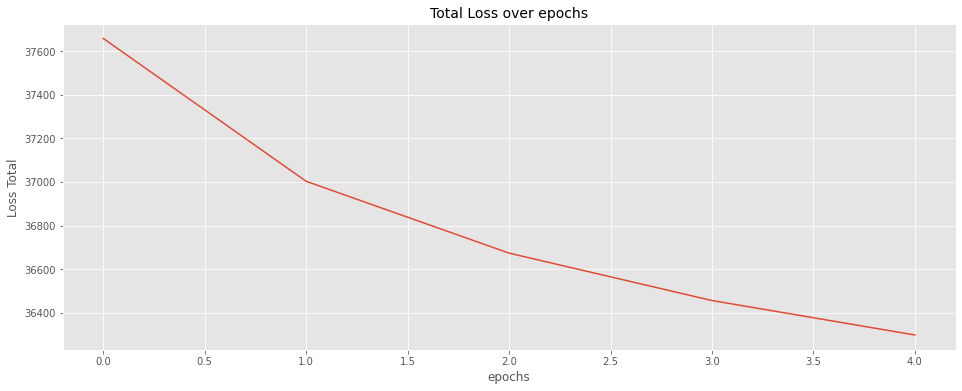

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()

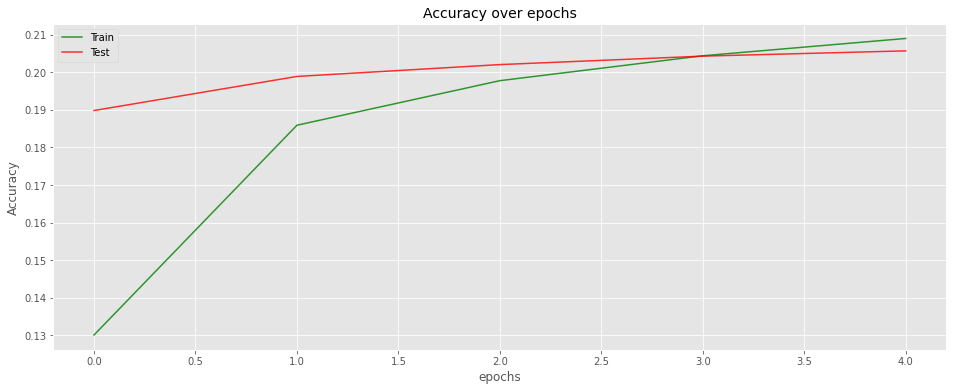

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train.history['factorized_top_k/top_100_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train.history['val_factorized_top_k/top_100_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

Test set performance is much worse than training performance. This is due to two factors:

- Our model is likely to perform better on the data that it has seen, simply because it can memorize it. This overfitting phenomenon is especially strong when models have many parameters. It can be mediated by model regularization and use of user and movie features that help the model generalize better to unseen data.
- The model is re-recommending some of users' already watched movies. These known-positive watches can crowd out test movies out of top K recommendations.

The second phenomenon can be tackled by excluding previously seen movies from test recommendations. This approach is relatively common in the recommender systems literature, but we don't follow it in these tutorials. If not recommending past watches is important, we should expect appropriately specified models to learn this behaviour automatically from past user history and contextual information. Additionally, it is often appropriate to recommend the same item multiple times (say, an evergreen TV series or a regularly purchased item).

## Making predictions

Now that we have a model, we would like to be able to make predictions. We can use the tfrs.layers.factorized_top_k.BruteForce layer to do this.

In [ ]:
# Features of all the available movies.
movies = tfds.load("movielens/1m-movies", split="train", shuffle_files=True)

#The movies dataset contains the movie id, movie title, and data on what genres it belongs to. Note that the genres are encoded with integer labels:
#View the data from movies dataset:
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

movies = movies.map(lambda x: x["movie_title"])

{'movie_genres': array([7]),
 'movie_id': b'1486',
 'movie_title': b'Quiet Room, The (1996)'}


In [ ]:
# Recommend the 5 best movies for user 42:

# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

# recommends movies out of the entire movies dataset.
index.index(movies.batch(100).map(model.movie_model), movies)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :5]}")

## Model serving

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In TFRS, both components can be packaged into a single exportable model, giving us a model that takes the raw user id and returns the titles of top movies for that user. This is done via exporting the model to a SavedModel format, which makes it possible to serve using TensorFlow Serving.

To deploy a model like this, we simply export the BruteForce layer we created above:

In [ ]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
    path = os.path.join(tmp, "model")

  # Save the index.
    index.save(path)

  # Load it back; can also be done in TensorFlow Serving.
    loaded = tf.keras.models.load_model(path)

  # Pass a user id in, get top predicted movie titles back.
    scores, titles = loaded(["42"])
    
    print(f"Recommendations: {titles[0][:5]}")

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

## Tuning Retrieval (The Two Towers Model)

### Increase embedding_dimension from 32 to 64

In [ ]:
#Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
embedding_dimension = 64

In [ ]:
#We define the embedding on the user side, we must transform the user ids into a vector representation:
#we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an Embedding layer:
user_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  #User_ids vocabulary: list of unique integers that represents each user_id
                                  vocabulary=unique_user_ids, mask_token=None),
                                  # We add an additional embedding to account for unknown tokens.
                                  tf.keras.layers.Embedding(len(unique_user_ids) + 1, 
                                  embedding_dimension)#embedding layer with a vector size of 64
                                ])

So, basically we want an embedding layer for however many user ids we have where each one is represented by a vector of 64 floating point values that basically represents in that 64-dimensional space how similar users.

In [ ]:
# We now define the embedding of the movie portion 
movie_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  vocabulary=unique_movie_titles, mask_token=None),
                                  tf.keras.layers.Embedding(len(unique_movie_titles) + 1,
                                  embedding_dimension) #embedding layer with a vector size of 64
                                 ])

#We define the desired metrics : FactorizedTopK
metrics = tfrs.metrics.FactorizedTopK(
                                     candidates=movies.batch(128).map(movie_model)
                                     )

#The Retrieval task is defined according to the FactorizedTopK metrics:
task = tfrs.tasks.Retrieval(
                            metrics=metrics
                           )

#Let's first instantiate the model.
model_1 = MovielensModel(user_model, movie_model)

model_1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)) # learning_rate default=0.001

# Then, let's train the model:
history_train_1 = model_1.fit(cached_train, validation_data = cached_test, epochs=2)

Epoch 1/2
92/92 [==============================] - 284s 3s/step - factorized_top_k/top_1_categorical_accuracy: 1.5064e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0052 - factorized_top_k/top_10_categorical_accuracy: 0.0123 - factorized_top_k/top_50_categorical_accuracy: 0.0677 - factorized_top_k/top_100_categorical_accuracy: 0.1271 - loss: 71041.4379 - regularization_loss: 0.0000e+00 - total_loss: 71041.4379 - val_factorized_top_k/top_1_categorical_accuracy: 0.0023 - val_factorized_top_k/top_5_categorical_accuracy: 0.0157 - val_factorized_top_k/top_10_categorical_accuracy: 0.0298 - val_factorized_top_k/top_50_categorical_accuracy: 0.1181 - val_factorized_top_k/top_100_categorical_accuracy: 0.1974 - val_loss: 929.6202 - val_regularization_loss: 0.0000e+00 - val_total_loss: 929.6202
Epoch 2/2
92/92 [==============================] - 280s 3s/step - factorized_top_k/top_1_categorical_accuracy: 2.6928e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0121 - factorized_top_k/top_1

In [ ]:
#Evaluate the Base model
model_1.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 81s 656ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0028 - factorized_top_k/top_5_categorical_accuracy: 0.0180 - factorized_top_k/top_10_categorical_accuracy: 0.0342 - factorized_top_k/top_50_categorical_accuracy: 0.1297 - factorized_top_k/top_100_categorical_accuracy: 0.2131 - loss: 14072.2262 - regularization_loss: 0.0000e+00 - total_loss: 14072.2262


{'factorized_top_k/top_100_categorical_accuracy': 0.21307967603206635,
 'factorized_top_k/top_10_categorical_accuracy': 0.03419288620352745,
 'factorized_top_k/top_1_categorical_accuracy': 0.0027674243319779634,
 'factorized_top_k/top_50_categorical_accuracy': 0.12972502410411835,
 'factorized_top_k/top_5_categorical_accuracy': 0.017956264317035675,
 'loss': 903.2338256835938,
 'regularization_loss': 0,
 'total_loss': 903.2338256835938}

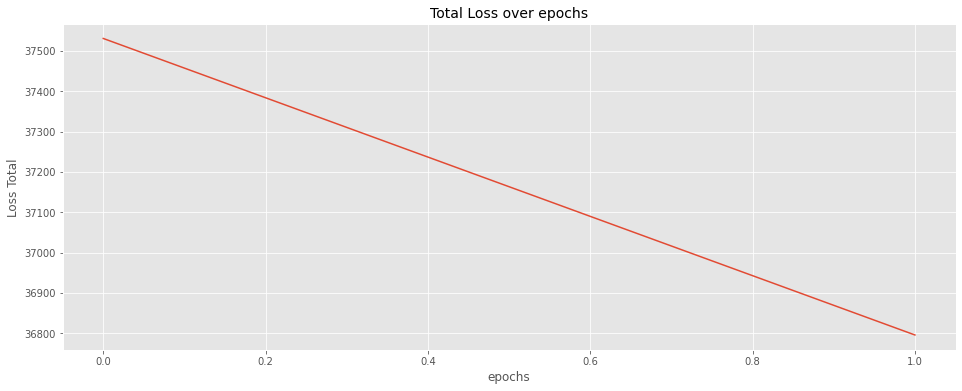

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_1.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()

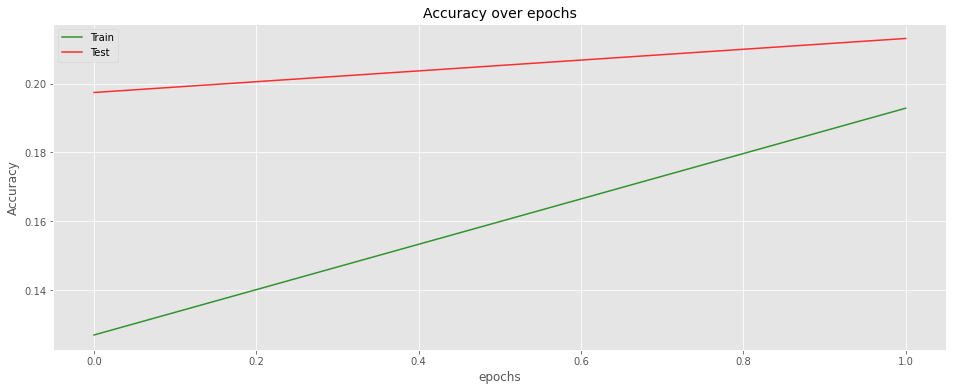

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_1.history['factorized_top_k/top_100_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train_1.history['val_factorized_top_k/top_100_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

### Reduce Adagrad learning_rate

learning_rate = 0.01

In [ ]:
#Let's first instantiate the model.
model_2 = MovielensModel(user_model, movie_model)

model_2.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01)) # learning_rate default=0.001

# Then, let's train the model:
history_train_2 = model_2.fit(cached_train, validation_data = cached_test, epochs=2)

Epoch 1/2
92/92 [==============================] - 279s 3s/step - factorized_top_k/top_1_categorical_accuracy: 2.3195e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0182 - factorized_top_k/top_10_categorical_accuracy: 0.0369 - factorized_top_k/top_50_categorical_accuracy: 0.1406 - factorized_top_k/top_100_categorical_accuracy: 0.2284 - loss: 67388.2888 - regularization_loss: 0.0000e+00 - total_loss: 67388.2888 - val_factorized_top_k/top_1_categorical_accuracy: 0.0029 - val_factorized_top_k/top_5_categorical_accuracy: 0.0186 - val_factorized_top_k/top_10_categorical_accuracy: 0.0356 - val_factorized_top_k/top_50_categorical_accuracy: 0.1335 - val_factorized_top_k/top_100_categorical_accuracy: 0.2187 - val_loss: 898.6080 - val_regularization_loss: 0.0000e+00 - val_total_loss: 898.6080
Epoch 2/2
92/92 [==============================] - 279s 3s/step - factorized_top_k/top_1_categorical_accuracy: 2.2795e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0196 - factorized_top_k/top_1

In [ ]:
#Evaluate the Base model
model_2.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 80s 651ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0028 - factorized_top_k/top_5_categorical_accuracy: 0.0190 - factorized_top_k/top_10_categorical_accuracy: 0.0360 - factorized_top_k/top_50_categorical_accuracy: 0.1349 - factorized_top_k/top_100_categorical_accuracy: 0.2206 - loss: 14006.8701 - regularization_loss: 0.0000e+00 - total_loss: 14006.8701


{'factorized_top_k/top_100_categorical_accuracy': 0.2205861210823059,
 'factorized_top_k/top_10_categorical_accuracy': 0.036028504371643066,
 'factorized_top_k/top_1_categorical_accuracy': 0.002843408612534404,
 'factorized_top_k/top_50_categorical_accuracy': 0.13492393493652344,
 'factorized_top_k/top_5_categorical_accuracy': 0.018952058628201485,
 'loss': 896.7573852539062,
 'regularization_loss': 0,
 'total_loss': 896.7573852539062}

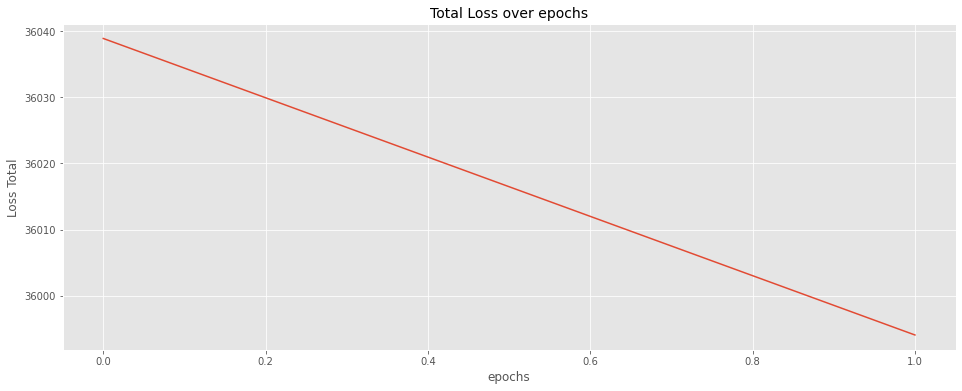

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_2.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()

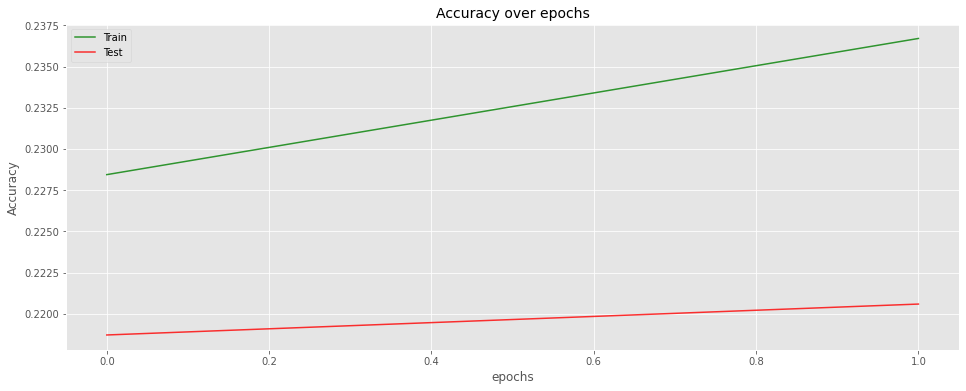

In [ ]:
plt.subplots(figsize = (16,6))
plt.plot(history_train_2.history['factorized_top_k/top_100_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train_2.history['val_factorized_top_k/top_100_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

## Tuning Summary

As we can see below, we managed to improve accuracy and reduce loss by: 

 1. Increase embedding_dimension from 32 -> 64
 2. Decreasing learning_rate 0.1 -> 0.01


| Tuning | top_1_accuracy |top_5_accuracy | top_10_accuracy | top_50_accuracy | top_100_accuracy|loss|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:
|**Baseline Model:** embedding_dimension 32, learning_rate 0.1, epochs=5 | 0.0026 | 0.0169 | 0.0317 | 0.1237 | 0.2056 | 891.81 |
|**Model_1:** embedding_dimension 32 -> 64, learning_rate 0.1 , epochs=2| 0.0027 | 0.0179 | 0.0341 | 0.1297 | 0.2130 | 903.23 |
|**Model_2:** embedding_dimension 64, learning_rate 0.1 -> 0.01, epochs=2| 0.0028 | 0.0189 | 0.0360 | 0.1349 | 0.2205 | 896.75 |